# **Introduction:**

In this analysis, we explore the application of various machine learning tools for predicting **Apple Inc. stock prices**. Predicting stock prices is a complex task due to the dynamic and noisy nature of financial markets. However, using advanced machine learning techniques can help capture patterns in historical data, providing valuable insights for future price predictions.

We will compare three distinct approaches: **Kalman Filter (KF)**, **Extended Kalman Filter (EKF)**, and **Linear Regression**.

- The **Kalman Filter (KF)** is a recursive state estimation method that is widely used for tracking and prediction in time series data. It is particularly suitable for systems where measurements are noisy and change over time, such as stock prices.
  
- The **Extended Kalman Filter (EKF)** is an extension of the Kalman Filter that can handle nonlinear models, making it more flexible for modeling complex financial systems.

- **Linear Regression**, a classical machine learning technique, is used here as a benchmark model. Despite its simplicity, it is widely used in financial prediction tasks for identifying linear relationships between stock prices and various features, such as historical prices and market indicators.

By applying these models to Apple stock price data, we aim to evaluate their performance in terms of prediction accuracy, using metrics like **Mean Squared Error (MSE)**, and assess the effectiveness of each method in the context of financial forecasting. The goal is to demonstrate the power and importance of machine learning tools in making informed predictions and decisions in the volatile world of stock markets.

In [ ]:
!pip install pykalman
!pip install filterpy

In [ ]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from IPython.display import display
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import datetime as dt
import yfinance as yf
import warnings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (8,6)
%config InlineBackend.figure_formats = ['svg']

In [ ]:
import os

file_path = 'aapl_2014_2023.csv'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file '{file_path}' does not exist.")

df = pd.read_csv(file_path)

In [ ]:
display(df)

,date,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,ema_50,sma_100,ema_100,macd,bollinger,TrueRange,atr_7,atr_14,target
0,2014-01-02,19.845715,19.893929,19.715000,19.754642,234684800,44.149614,50.996175,-105.071637,-42.411877,19.282236,19.265060,18.372604,18.484713,0.194637,19.979268,0.321428,0.305722,0.316301,bearish
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,392467600,33.094332,43.883529,-152.150999,-124.511983,19.297314,19.267243,18.398896,18.501371,0.132887,19.936375,0.473929,0.329752,0.327561,bullish
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,412610800,37.525661,45.858019,-132.306490,-130.122350,19.310864,19.273472,18.418311,18.519794,0.091398,19.893571,0.471428,0.349991,0.337837,bearish
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,317209200,34.055624,43.675708,-89.587009,-108.089019,19.316671,19.274008,18.433146,18.535080,0.046768,19.857893,0.287141,0.341013,0.334216,bullish
4,2014-01-08,19.243214,19.484285,19.238930,19.409286,258529600,39.768497,46.104107,-58.525539,-82.150032,19.329171,19.279313,18.449414,18.552493,0.021012,19.816875,0.245355,0.327347,0.327868,bearish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,2023-12-22,195.179993,195.410004,192.970001,193.600006,37122800,43.616382,54.609714,-125.833264,-50.518147,185.398801,188.226229,181.768301,183.982764,2.636317,193.668500,2.440003,2.744973,2.790613,neutral
2512,2023-12-26,193.610001,193.889999,192.830002,193.050003,28919300,40.755941,53.026883,-128.310846,-89.108636,185.682801,188.415396,181.787101,184.162313,2.306308,193.831501,1.059997,2.504262,2.666998,neutral
2513,2023-12-27,192.490005,193.500000,191.089996,193.149994,48087700,41.568718,53.291938,-115.745604,-116.860553,185.971400,188.601067,181.898701,184.340287,2.029448,193.969001,2.410004,2.490796,2.648641,neutral
2514,2023-12-28,194.139999,194.660004,193.169998,193.580002,34049900,45.331639,54.481470,-36.040033,-56.848224,186.300001,188.796319,182.046001,184.523252,1.823710,194.179501,1.510010,2.350684,2.567310,bearish


In [ ]:
!pip install tabulate

In [ ]:
from tabulate import tabulate

In [ ]:
print(tabulate(df.info(), headers='keys', tablefmt='pretty', showindex=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       2516 non-null   datetime64[ns]
 1   open       2516 non-null   float64       
 2   high       2516 non-null   float64       
 3   low        2516 non-null   float64       
 4   close      2516 non-null   float64       
 5   volume     2516 non-null   int64         
 6   rsi_7      2516 non-null   float64       
 7   rsi_14     2516 non-null   float64       
 8   cci_7      2516 non-null   float64       
 9   cci_14     2516 non-null   float64       
 10  sma_50     2516 non-null   float64       
 11  ema_50     2516 non-null   float64       
 12  sma_100    2516 non-null   float64       
 13  ema_100    2516 non-null   float64       
 14  macd       2516 non-null   float64       
 15  bollinger  2516 non-null   float64       
 16  TrueRange  2516 non-null   float64       


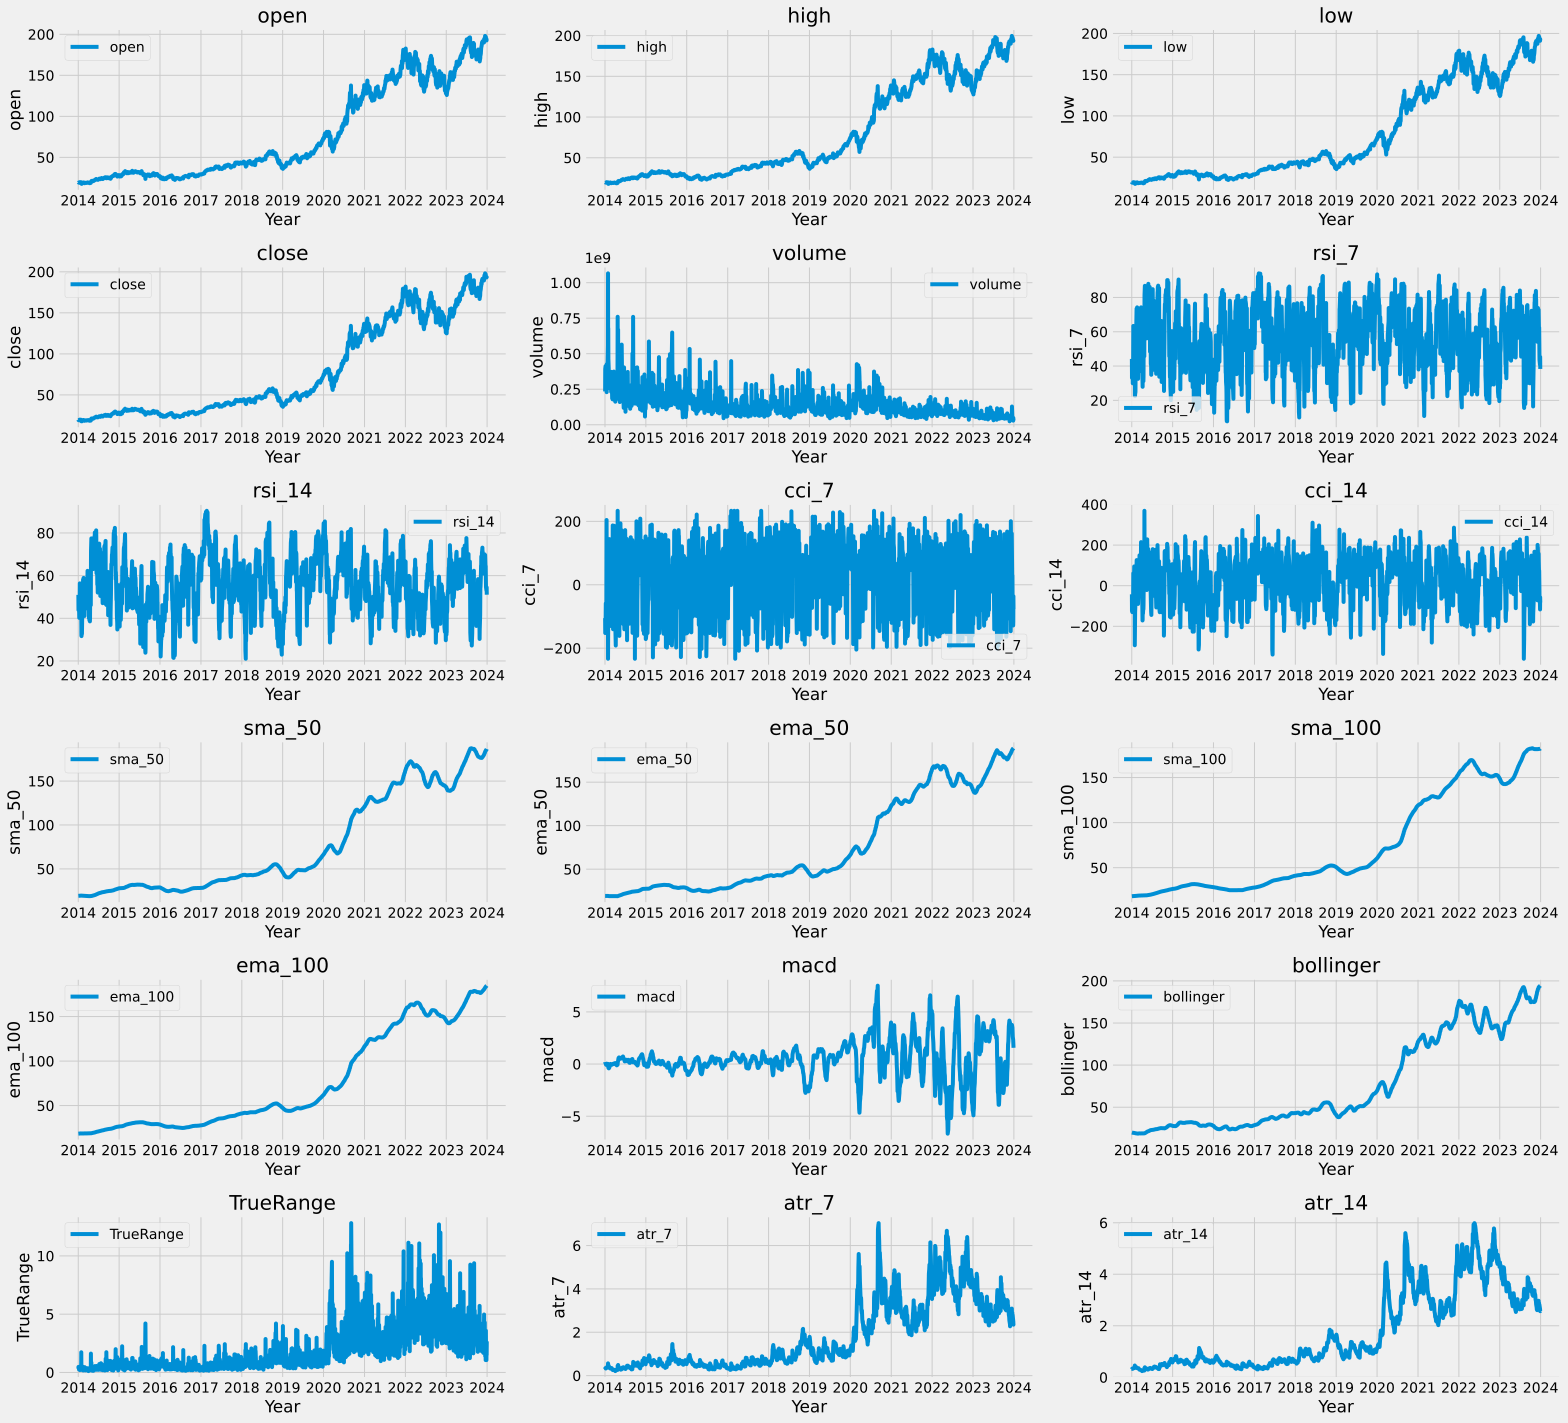

In [ ]:
df['date'] = pd.to_datetime(df['date'])

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(22, 20))
features = ['open', 'high', 'low', 'close', 'volume', 'rsi_7', 'rsi_14', 'cci_7', 'cci_14',
           'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14']

axes = axes.flatten()

for i, col in enumerate(features):
    axes[i].plot(df['date'], df[col], label=col)
    axes[i].set_title(col)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(col)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
display(df.describe())

,date,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,ema_50,sma_100,ema_100,macd,bollinger,TrueRange,atr_7,atr_14
count,2516,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000
mean,2018-12-31 00:18:53.227344896,77.856671,78.704468,77.060193,77.920721,1.366662e+08,55.829312,55.519634,18.095222,25.615576,76.247802,76.268259,74.643895,74.650532,0.477411,77.261412,1.819842,1.814850,1.808171
min,2014-01-02 00:00:00,17.684999,17.911785,17.626785,17.849285,2.404830e+07,7.771611,21.024935,-233.333333,-359.820078,18.865621,18.936409,18.372604,18.484713,-6.673117,18.645339,0.115000,0.208006,0.241328
25%,2016-06-30 18:00:00,29.740001,29.976250,29.554375,29.803750,8.138358e+07,42.223776,45.982864,-67.510511,-62.798902,29.016362,29.150426,29.313956,29.263913,-0.208277,29.462344,0.481874,0.558372,0.571540
50%,2019-01-01 00:00:00,47.963749,48.534999,47.743749,48.107500,1.121606e+08,56.567948,55.840878,35.924386,45.301983,48.321325,47.546591,46.741750,46.984332,0.344944,47.652813,1.025000,1.012167,1.020535
75%,2021-06-30 06:00:00,134.792496,135.995002,133.325004,134.562497,1.668892e+08,70.072551,64.891153,99.248997,108.764720,131.678000,131.059003,129.198700,128.011330,1.180283,133.377500,2.732506,3.002147,3.021852
max,2023-12-29 00:00:00,198.020004,199.619995,197.000000,198.110001,1.065523e+09,94.046150,90.402170,233.333333,368.904964,187.442600,188.942738,182.538301,184.681801,7.511570,194.308501,12.809998,7.034749,5.984262
std,NaN,56.171865,56.808974,55.581734,56.226768,8.403551e+07,17.720405,12.917822,99.975348,108.636294,55.164687,55.126114,54.292014,54.142049,1.820108,55.795529,1.829370,1.557822,1.520721


# **Mathematical Formulation of the Kalman Filter**

The Kalman Filter is a powerful recursive Bayesian estimator used for estimating the state of a dynamic system from a series of noisy measurements. It operates in two main steps: the **Prediction Step** and the **Update (Correction) Step**. The Kalman Filter is widely used in various fields such as robotics, navigation, finance, and signal processing due to its efficiency and optimality under certain conditions.

## **Prediction Step**

### **State Prediction:**
The state prediction step estimates the next state of the system based on the current state and the control input (if any). The state prediction equation is given by:

$$
\hat{x}_k^- = A \hat{x}_{k-1} + B u_k
$$

where:
- $ \hat{x}_k^- $ is the **predicted state estimate** at time step $k$.
- $ A $ is the **state transition matrix**, which describes how the state evolves from one time step to the next without considering the control input or noise.
- $ B $ is the **control input matrix**, which describes how the control input $u_k$ affects the state.
- $ u_k $ is the **control input** at time step $k$.
- $ \hat{x}_{k-1} $ is the **previous state estimate** at time step $k-1$.

### **Covariance Prediction:**
The covariance prediction step estimates the uncertainty in the predicted state. The covariance prediction equation is given by:

$$
P_k^- = A P_{k-1} A^T + Q
$$

where:
- $ P_k^- $ is the **predicted covariance** at time step $k$.
- $ Q $ is the **process noise covariance**, which represents the uncertainty in the process model.
- $ P_{k-1} $ is the **previous covariance estimate** at time step $k-1$.

The process noise covariance $Q$ accounts for the fact that the system model is not perfect and that there may be external disturbances affecting the system.

## **Update (Correction) Step**

### **Kalman Gain:**
The Kalman Gain is a weighting factor that determines how much weight should be given to the new measurement versus the predicted state. The Kalman Gain is calculated as:

$$
K_k = P_k^- H^T (H P_k^- H^T + R)^{-1}
$$

where:
- $ K_k $ is the **Kalman Gain** at time step $k$.
- $ H $ is the **observation matrix**, which maps the state space into the measurement space.
- $ R $ is the **measurement noise covariance**, which represents the uncertainty in the measurements.

The Kalman Gain essentially balances the confidence in the predicted state and the new measurement. If the measurement noise is small (i.e., $R$ is small), the Kalman Gain will be high, giving more weight to the measurement. Conversely, if the measurement noise is large, the Kalman Gain will be low, giving more weight to the prediction.

### **State Update:**
The state update step adjusts the predicted state estimate using the new measurement. The state update equation is given by:

$$
\hat{x}_k = \hat{x}_k^- + K_k (z_k - H \hat{x}_k^-)
$$

where:
- $ \hat{x}_k $ is the **updated state estimate** at time step $k$.
- $ z_k $ is the **observed measurement** at time step $k$.
- $ z_k - H \hat{x}_k^- $ is the **measurement residual**, which represents the difference between the observed measurement and the predicted measurement.

The measurement residual is a crucial part of the update step, as it provides the information needed to correct the predicted state.

### **Covariance Update:**
The covariance update step adjusts the predicted covariance to reflect the new information gained from the measurement. The covariance update equation is given by:

$$
P_k = (I - K_k H) P_k^-
$$

where:
- $ P_k $ is the **updated covariance** at time step $k$.
- $ I $ is the **identity matrix**.

The updated covariance reflects the reduced uncertainty in the state estimate after incorporating the new measurement.

---

# **Extended Kalman Filter (EKF)**

The Extended Kalman Filter (EKF) is a nonlinear version of the Kalman Filter that linearizes the system model and measurement model around the current state estimate. The EKF is used when the system dynamics or measurement models are nonlinear, which is often the case in real-world applications.

### **EKF Prediction Step:**
In the EKF, the state prediction step is similar to the standard Kalman Filter, but the state transition matrix $A$ is replaced by the Jacobian matrix of the nonlinear state transition function $f(x_{k-1}, u_k)$ evaluated at the current state estimate:

$$
\hat{x}_k^- = f(\hat{x}_{k-1}, u_k)
$$

The covariance prediction is also updated using the Jacobian matrix:

$$
P_k^- = F_k P_{k-1} F_k^T + Q
$$

where $F_k$ is the Jacobian matrix of the state transition function $f$ with respect to the state $x$.

### **EKF Update Step:**
In the update step, the observation matrix $H$ is replaced by the Jacobian matrix of the nonlinear measurement function $h(x_k)$ evaluated at the predicted state estimate:

$$
K_k = P_k^- H_k^T (H_k P_k^- H_k^T + R)^{-1}
$$

where $H_k$ is the Jacobian matrix of the measurement function $h$ with respect to the state $x$.

The state and covariance updates are then performed similarly to the standard Kalman Filter:

$$
\hat{x}_k = \hat{x}_k^- + K_k (z_k - h(\hat{x}_k^-))
$$

$$
P_k = (I - K_k H_k) P_k^-
$$

The EKF is a powerful tool for dealing with nonlinear systems, but it has some limitations. The linearization process can introduce errors, especially if the system is highly nonlinear or if the initial state estimate is far from the true state. In such cases, more advanced techniques like the Unscented Kalman Filter (UKF) or Particle Filter may be more appropriate.

# **Mathematical Formulation of the Kalman Filter**

The Kalman Filter is a recursive Bayesian estimator consisting of two steps:

- **Prediction Step**: Estimates the next state.
- **Update (Correction) Step**: Adjusts the estimate using observations.

## **Prediction Step**
### **State Prediction:**
$$
\hat{x}_k^- = A \hat{x}_{k-1} + B u_k
$$
where:
- $ \hat{x}_k^- $ is the predicted state estimate.
- $ A $ is the **state transition matrix**.
- $ B $ is the **control input matrix**.
- $ u_k $ is the **control input**.
- $ \hat{x}_{k-1} $ is the previous estimate.

### **Covariance Prediction:**
$$
P_k^- = A P_{k-1} A^T + Q
$$
where:
- $ P_k^- $ is the predicted covariance.
- $ Q $ is the **process noise covariance**.
- $ P_{k-1} $ is the previous covariance estimate.

## **Update (Correction) Step**
### **Kalman Gain:**
$$
K_k = P_k^- H^T (H P_k^- H^T + R)^{-1}
$$
where:
- $ K_k $ is the **Kalman gain**.
- $ H $ is the **observation matrix**.
- $ R $ is the **measurement noise covariance**.

### **State Update:**
$$
\hat{x}_k = \hat{x}_k^- + K_k (z_k - H \hat{x}_k^-)
$$
where:
- $ \hat{x}_k $ is the updated state estimate.
- $ z_k $ is the observed measurement.
- $ z_k - H \hat{x}_k^- $ is the measurement residual.

### **Covariance Update:**
$$
P_k = (I - K_k H) P_k^-
$$
where:
- $ P_k $ is the updated covariance.
- $ I $ is the identity matrix.

---

# **Extended Kalman Filter (EKF)**

The Extended Kalman Filter (EKF) is a nonlinear version of the Kalman Filter that linearizes the system model and measurement model around the current state estimate. The EKF is used when the system dynamics or measurement models are nonlinear, which is often the case in real-world applications.

### **EKF Prediction Step:**
In the EKF, the state prediction step is similar to the standard Kalman Filter, but the state transition matrix $A$ is replaced by the Jacobian matrix of the nonlinear state transition function $f(x_{k-1}, u_k)$ evaluated at the current state estimate:

$$
\hat{x}_k^- = f(\hat{x}_{k-1}, u_k)
$$

The covariance prediction is also updated using the Jacobian matrix:

$$
P_k^- = F_k P_{k-1} F_k^T + Q
$$

where $F_k$ is the Jacobian matrix of the state transition function $f$ with respect to the state $x$.

### **EKF Update Step:**
In the update step, the observation matrix $H$ is replaced by the Jacobian matrix of the nonlinear measurement function $h(x_k)$ evaluated at the predicted state estimate:

$$
K_k = P_k^- H_k^T (H_k P_k^- H_k^T + R)^{-1}
$$

where $H_k$ is the Jacobian matrix of the measurement function $h$ with respect to the state $x$.

The state and covariance updates are then performed similarly to the standard Kalman Filter:

$$
\hat{x}_k = \hat{x}_k^- + K_k (z_k - h(\hat{x}_k^-))
$$

$$
P_k = (I - K_k H_k) P_k^-
$$

---

# **Python Implementation**
In this Python code, the Kalman Filter is defined as:

```python
kf = KalmanFilter(
    transition_matrices=[1],                # A = 1 (random walk)
    observation_matrices=[1],                # H = 1 (direct observation)
    initial_state_mean=df['close'].values[0], # Initial price
    initial_state_covariance=1,              # Initial variance
    observation_covariance=1,                # Measurement noise R
    transition_covariance=0.01               # Process noise Q
)



In [ ]:
from filterpy.kalman import ExtendedKalmanFilter
from pykalman import KalmanFilter

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
kf = KalmanFilter(
    transition_matrices=[1],                # A = 1 (random walk)
    observation_matrices=[1],                # H = 1 (direct observation)
    initial_state_mean=df['close'].values[0], # Initial price
    initial_state_covariance=1,              # Initial variance
    observation_covariance=1,                # Measurement noise R
    transition_covariance=0.01               # Process noise Q
)

In [ ]:
state_means, state_covariances = kf.filter(df['close'].values)
df['filtered_close'] = state_means[:, 0]

In [ ]:
def hx(x):
    """Measurement function (maps state to measurement)."""
    return np.array([x[0]])

def fx(x, dt):
    """State transition function (predicts next state)."""
    return np.array([x[0]])

def HJacobian(x):
    """Jacobian of the measurement function."""
    return np.array([[1]])

def FJacobian(x, dt):
    """Jacobian of the state transition function."""
    return np.array([[1]])

ekf = ExtendedKalmanFilter(dim_x=1, dim_z=1)
ekf.x = np.array([df['close'].values[0]])  # Initial state
ekf.F = np.array([[1]])  # State transition matrix
ekf.H = np.array([[1]])  # Measurement function
ekf.P *= 1000  # Initial state covariance
ekf.R = 1  # Measurement noise covariance
ekf.Q = 0.01  # Process noise covariance

filtered_close_ekf = []
for z in df['close'].values:
    ekf.predict()
    ekf.update(np.array([z]), HJacobian=HJacobian, Hx=hx)
    filtered_close_ekf.append(ekf.x[0])

In [ ]:
df['filtered_close_ekf'] = filtered_close_ekf

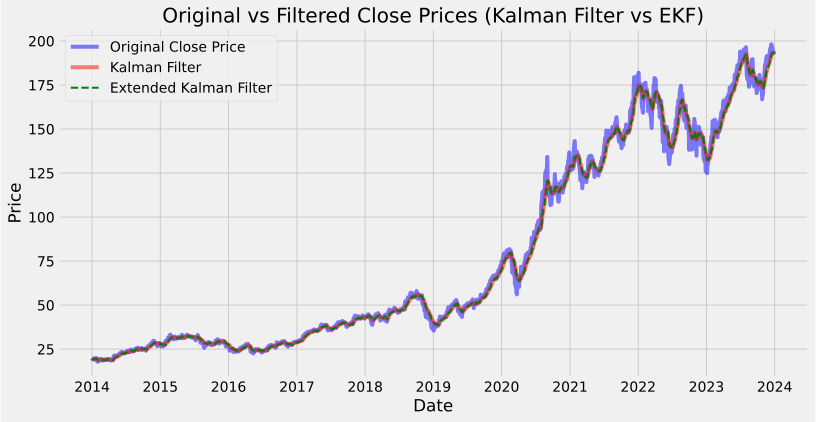

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['close'], label='Original Close Price', color='blue', linewidth=4, alpha=0.5)
plt.plot(df['date'], df['filtered_close'], label='Kalman Filter', color='red', linewidth=4, alpha=0.5 )
plt.plot(df['date'], df['filtered_close_ekf'], label='Extended Kalman Filter', color='green', linestyle='--', linewidth=2)
plt.title('Original vs Filtered Close Prices (Kalman Filter vs EKF)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df[['date', 'close', 'filtered_close','filtered_close_ekf']].to_csv("kalman_predictions.csv", index=False)
filtered = pd.read_csv("kalman_predictions.csv")

In [ ]:
display(filtered)

,date,close,filtered_close,filtered_close_ekf
0,2014-01-02,19.754642,19.754642,19.754642
1,2014-01-03,19.320715,19.608084,19.536706
2,2014-01-06,19.426071,19.561121,19.499231
3,2014-01-07,19.287144,19.503210,19.444393
4,2014-01-08,19.409286,19.486187,19.436961
...,...,...,...,...
2511,2023-12-22,193.600006,193.325349,193.325349
2512,2023-12-26,193.050003,193.299157,193.299157
2513,2023-12-27,193.149994,193.284968,193.284968
2514,2023-12-28,193.580002,193.313033,193.313033


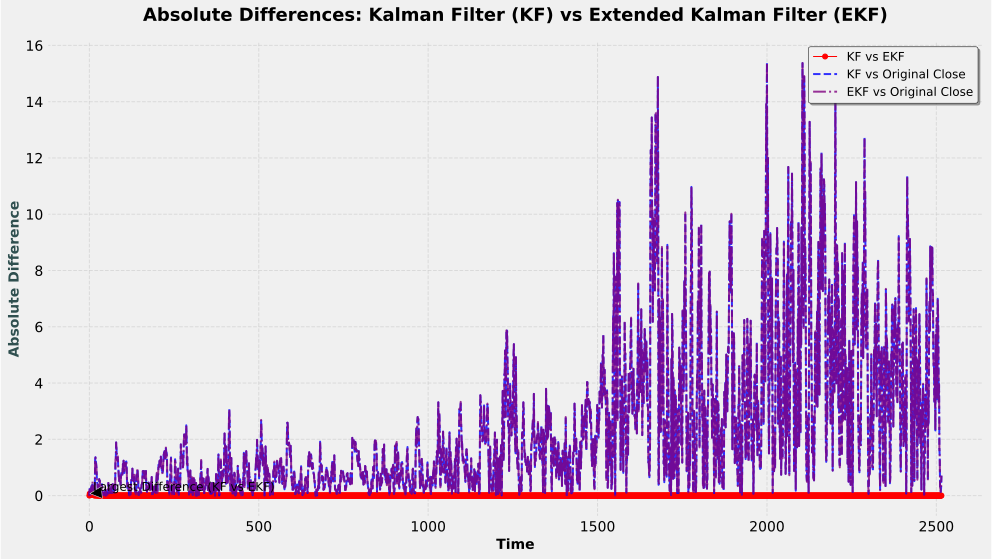

In [ ]:
abs_diff_kf_ekf = abs(df['filtered_close'] - df['filtered_close_ekf'])
abs_diff_close_ekf = abs(df['close'] - df['filtered_close_ekf'])
abs_diff_close_kf = abs(df['close'] - df['filtered_close'])

plt.figure(figsize=(14, 8))

plt.plot(abs_diff_kf_ekf, label='KF vs EKF', color='red', linewidth=1, linestyle='-', marker='o', markersize=5)
plt.plot(abs_diff_close_kf, label='KF vs Original Close', color='blue', linewidth=2, linestyle='--', alpha=0.8)
plt.plot(abs_diff_close_ekf, label='EKF vs Original Close', color='purple', linewidth=2, linestyle='-.', alpha=0.8)

plt.title('Absolute Differences: Kalman Filter (KF) vs Extended Kalman Filter (EKF)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel('Absolute Difference', fontsize=14, fontweight='bold', color='darkslategray' )

plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(fontsize=12, loc='upper right', framealpha=1, shadow=True, edgecolor='black')

plt.annotate('Largest Difference (KF vs EKF)',
             xy=(abs_diff_kf_ekf.idxmax(), abs_diff_kf_ekf.max()),
             xytext=(abs_diff_kf_ekf.idxmax() + 10, abs_diff_kf_ekf.max() + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, color='black')

plt.tight_layout()

plt.show()

**Mean Absolute Error (MAE):**

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

**Mean Squared Error (MSE):**

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

**Root Mean Squared Error (RMSE):**

$$
RMSE = \sqrt{MSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

---


- $ RMSE $ : Root Mean Squared Error.
- $ MSE $ : Mean Squared Error.
- $ n $ : Number of data points.
- $ y_i $ : Actual value.
- $ \hat{y}_i $ : Predicted value.

#### **Interpretation:**
- **MAE** gives the average absolute difference between predictions and actual values.
- **MSE** penalizes larger errors more than MAE because of squaring.
- **RMSE** is the square root of MSE, making it interpretable in the same unit as the target variable.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
mae_kf = mean_absolute_error(df['close'], df['filtered_close'])
mse_kf = mean_squared_error(df['close'], df['filtered_close'])
rmse_kf = np.sqrt(mse_kf)
mae_ekf = mean_absolute_error(df['close'], df['filtered_close_ekf'])
mse_ekf = mean_squared_error(df['close'], df['filtered_close_ekf'])
rmse_ekf = np.sqrt(mse_ekf)

In [ ]:
mae_kf = mean_absolute_error(df['close'], df['filtered_close'])
mse_kf = mean_squared_error(df['close'], df['filtered_close'])
rmse_kf = np.sqrt(mse_kf)

mae_ekf = mean_absolute_error(df['close'], df['filtered_close_ekf'])
mse_ekf = mean_squared_error(df['close'], df['filtered_close_ekf'])
rmse_ekf = np.sqrt(mse_ekf)

results = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE'],
    'Kalman Filter (KF)': [mae_kf, mse_kf, rmse_kf],
    'Extended Kalman Filter (EKF)': [mae_ekf, mse_ekf, rmse_ekf]
})

results.set_index('Metric', inplace=True)
results = results.applymap(lambda x: f"{x:.6f}")

print("Comparison of KF and EKF Performance:")
display(results)

if mae_ekf < mae_kf and mse_ekf < mse_kf:
    print("\nConclusion: EKF performs better than KF (lower MAE and MSE).")
elif mae_ekf > mae_kf and mse_ekf > mse_kf:
    print("\nConclusion: KF performs better than EKF (lower MAE and MSE).")
else:
    print("\nConclusion: Mixed results. KF and EKF perform differently depending on the metric:")
    if mae_ekf < mae_kf:
        print("- EKF has a lower MAE than KF.")
    else:
        print("- KF has a lower MAE than EKF.")
    if mse_ekf < mse_kf:
        print("- EKF has a lower MSE than KF.")
    else:
        print("- KF has a lower MSE than EKF.")

Comparison of KF and EKF Performance:


<ipython-input-251-8515ab28284e>:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results = results.applymap(lambda x: f"{x:.6f}")


,Kalman Filter (KF),Extended Kalman Filter (EKF)
Metric,,
MAE,2.358560,2.358429
MSE,12.492351,12.492269
RMSE,3.534452,3.534440



Conclusion: EKF performs better than KF (lower MAE and MSE).


# **Importance de l'Analyse des Données pour l'Utilisation de ML ou DL**

L'analyse des données est essentielle avant d'utiliser des modèles de Machine Learning (ML) ou de Deep Learning (DL). Elle permet de :

1. **Comprendre les données** : Identifier les tendances, relations et anomalies pour guider le prétraitement.
2. **Préparer les données** : Traiter les valeurs manquantes, normaliser les données et gérer les anomalies.
3. **Sélectionner les caractéristiques** : Choisir les variables les plus pertinentes pour améliorer les performances du modèle.
4. **Améliorer les résultats** : Éviter les biais et optimiser les performances en nettoyant les données.

En somme, une bonne analyse des données est clé pour des modèles robustes et précis.

In [ ]:
display(df["target"])

,target
0,bearish
1,bullish
2,bearish
3,bullish
4,bearish
...,...
2511,neutral
2512,neutral
2513,neutral
2514,bearish


In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud

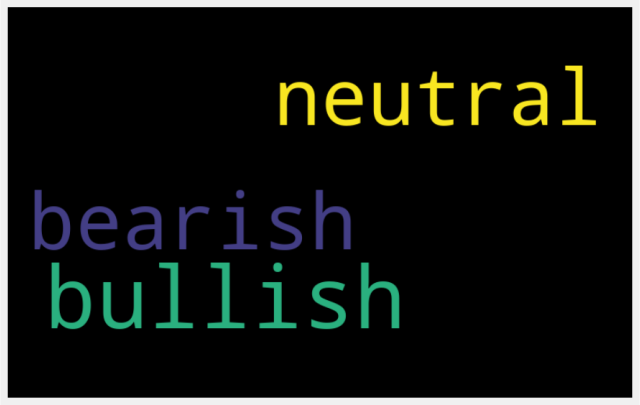

In [ ]:
all_words = ' '.join([text for text in df['target']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
print(df["target"].unique())

['bearish' 'bullish' 'neutral']


**Mapping Dictionary Explanation**

The `mapping` dictionary is used to convert categorical labels (e.g., "bearish", "neutral", "bullish") into numerical values. This is often necessary for machine learning models, as they typically require numerical input rather than text.

- `"bearish"` is mapped to `-1`, representing a negative or downward trend.
- `"neutral"` is mapped to `0`, representing no significant trend or a stable condition.
- `"bullish"` is mapped to `1`, representing a positive or upward trend.

For example:
- If the original data contains the label `"bullish"`, it will be replaced with `1`.
- If the original data contains the label `"bearish"`, it will be replaced with `-1`.

This mapping allows the data to be processed more efficiently by algorithms that rely on numerical computations.

In [ ]:
mapping = {"bearish": -1, "neutral": 0, "bullish": 1}
df["target"] = df["target"].map(mapping)
df.to_csv("updated_data.csv", index=False)
grouped_df = df.groupby("target")["close"].agg(['count', 'mean']).sort_values('count', ascending=False)
display(grouped_df)

,count,mean
target,,
1,951,78.319798
0,786,71.999528
-1,779,83.407929


In [ ]:
print(df["target"].unique())

[-1  1  0]


In [ ]:
import seaborn as sns

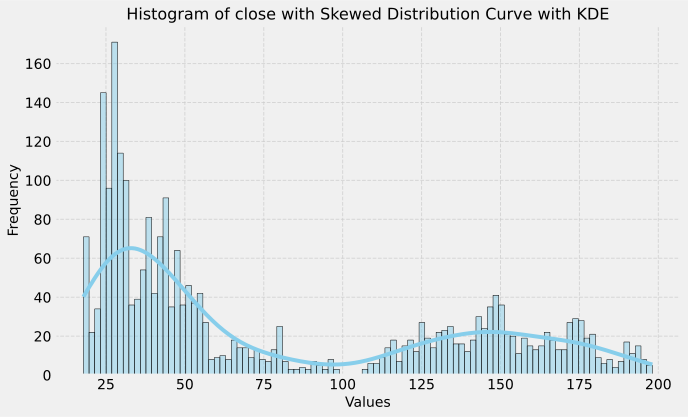

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['close'], bins=100, kde=True, color='skyblue', edgecolor='black')
plt.title('Histogram of close with Skewed Distribution Curve with KDE', fontsize=16)
plt.xlabel('Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

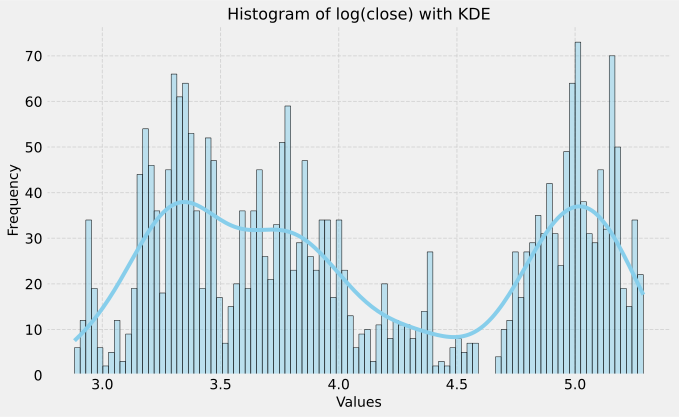

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log(df['close']), bins=100, kde=True, color='skyblue', edgecolor='black')
plt.title('Histogram of log(close) with KDE', fontsize=16)
plt.xlabel('Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

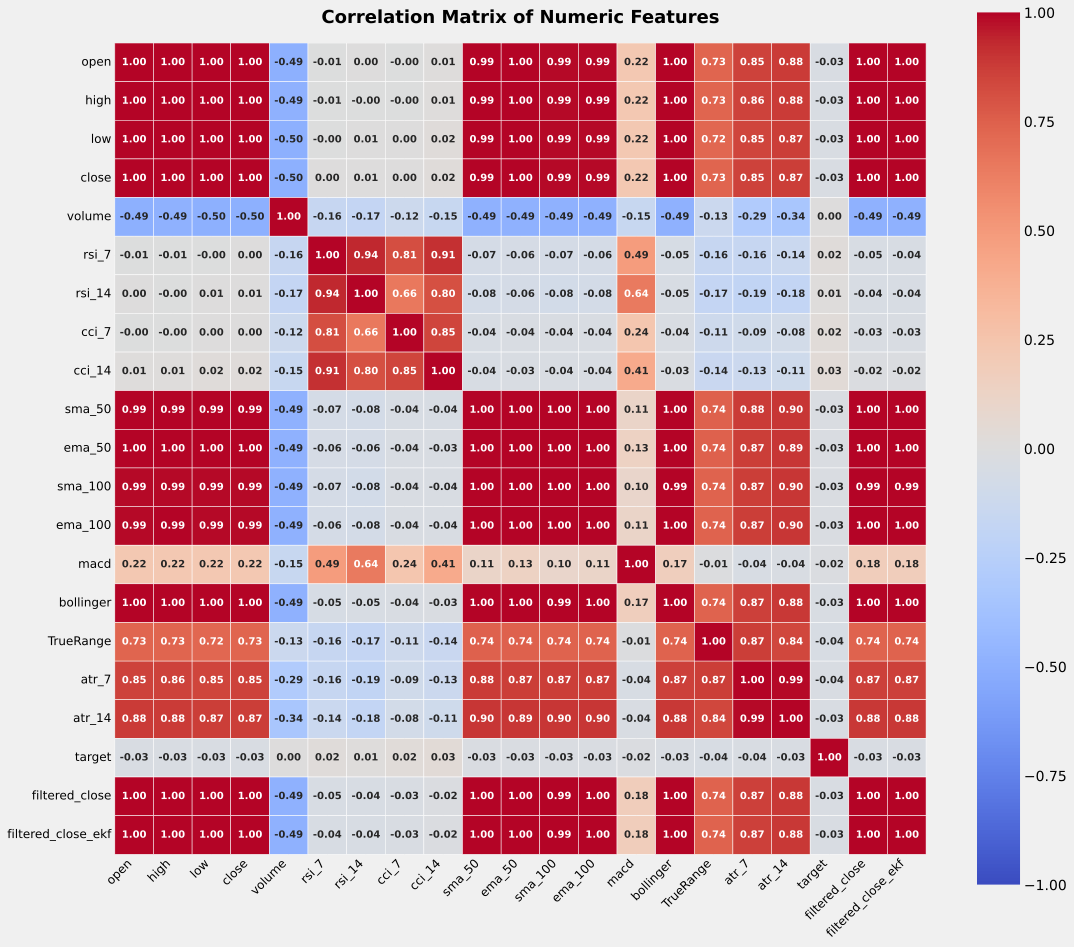

In [ ]:
numeric_df = df.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(16, 14))

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    annot_kws={'size': 10, 'weight': 'bold'},
    linewidths=0.5,
    linecolor='white',
    vmin=-1,
    vmax=1,
    square=True
)

plt.title('Correlation Matrix of Numeric Features', fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

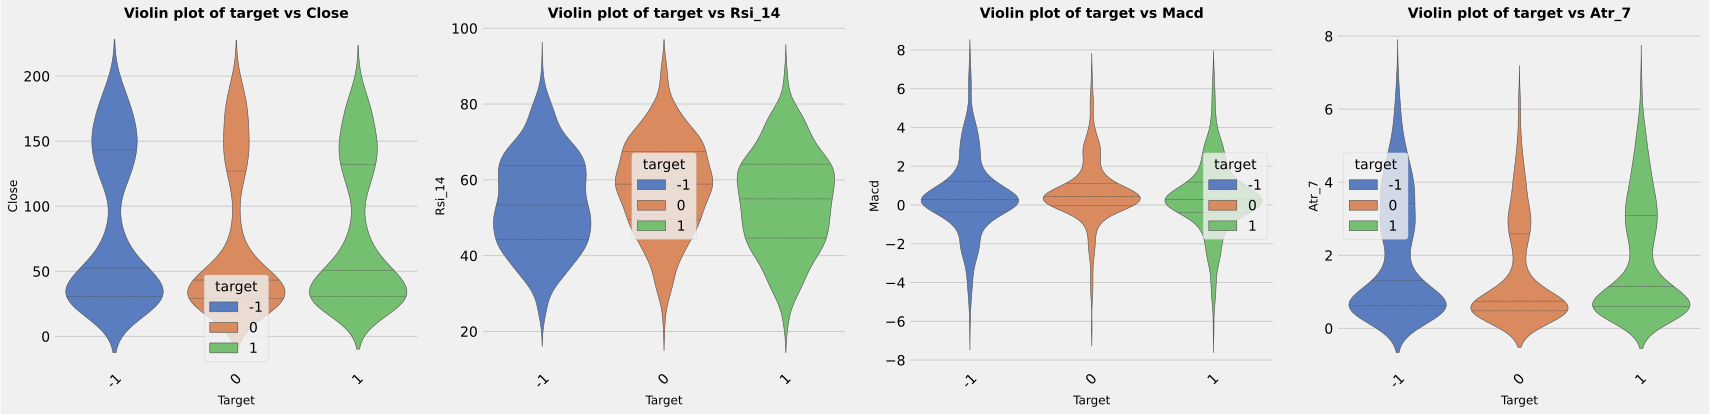

In [ ]:
variables = ['close', 'rsi_14', 'macd', 'atr_7']
titles = [f'Violin plot of target vs {var.capitalize()}' for var in variables]
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
for i, var in enumerate(variables):
    sns.violinplot(ax=axes[i], x='target', y=var, data=df, hue='target', palette='muted', inner='quart')
    axes[i].set_title(titles[i], fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Target', fontsize=12)
    axes[i].set_ylabel(var.capitalize(), fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

**Calculate features and technical indicators for each stock.**

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume
\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Close}) - \ln(\text{Open}))^2
\end{equation}

In [ ]:
pip install pandas_ta

In [ ]:
import pandas_ta

In [ ]:
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2) / 2 - (2 * np.log(2) - 1) * ((np.log(df['close']) - np.log(df['open']))**2)

df['rsi'] = pandas_ta.rsi(close=df['close'], length=20)

bb = pandas_ta.bbands(close=np.log1p(df['close']), length=20)
df[['bb_low', 'bb_mid', 'bb_high']] = bb.iloc[:, :3]

atr = pandas_ta.atr(df['high'], df['low'], df['close'], length=14)
df['atr'] = (atr - atr.mean()) / atr.std()

macd = pandas_ta.macd(close=df['close'], length=20)
df['macd'] = (macd.iloc[:, 0] - macd.iloc[:, 0].mean()) / macd.iloc[:, 0].std()

df['dollar_volume'] = (df['close'] * df['volume']) / 1e6

df.dropna(inplace=True)

In [ ]:
import yfinance as yf

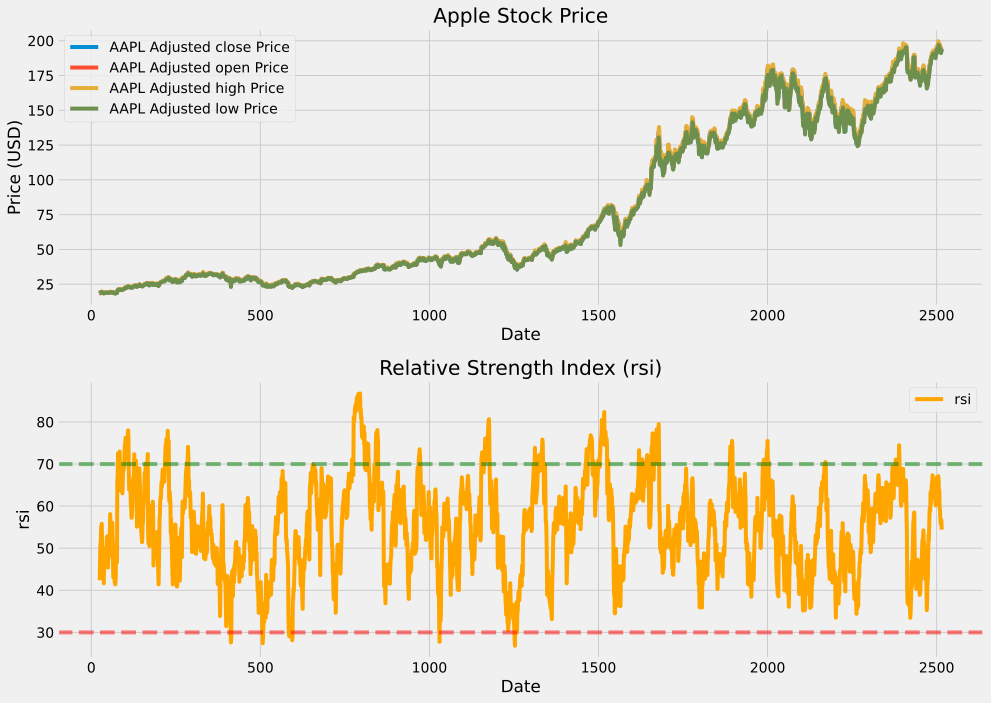

In [ ]:
plt.figure(figsize=(14, 10))

ax1 = plt.subplot(2, 1, 1)
ax1.plot(df['close'],  label='AAPL Adjusted close Price')
ax1.plot(df['open'], label='AAPL Adjusted open Price')
ax1.plot(df['high'], label='AAPL Adjusted high Price')
ax1.plot(df['low'], label='AAPL Adjusted low Price')
ax1.set_title('Apple Stock Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)')
ax1.legend()

ax2 = plt.subplot(2, 1, 2)
ax2.plot(df['rsi'], label='rsi', color='orange')
ax2.axhline(30, linestyle='--', alpha=0.5, color='red')
ax2.axhline(70, linestyle='--', alpha=0.5, color='green')
ax2.set_title('Relative Strength Index (rsi)')
ax2.set_xlabel('Date')
ax2.set_ylabel('rsi')
ax2.legend()

plt.tight_layout()
plt.show()

# **Les Réseaux de Neurones**

Les réseaux de neurones artificiels sont des modèles informatiques inspirés du cerveau humain, capables de reconnaître des motifs et de réaliser des tâches telles que la classification, la régression et la reconnaissance d'images. Ils sont constitués de neurones artificiels organisés en couches : la couche d'entrée, une ou plusieurs couches cachées, et la couche de sortie.

## Structure d'un Neurone Artificiel

Un neurone artificiel est une unité de calcul qui reçoit plusieurs entrées, les pondère, les somme, et applique une fonction d'activation pour produire une sortie. Mathématiquement, un neurone $i$ peut être décrit par l'équation suivante :

$$
y_i = \sigma\left( \sum_{j=1}^n w_{ij} z_j + b_i \right)
$$

où :
- $z_j$ sont les entrées,
- $w_{ij}$ sont les poids synaptiques,
- $b_i$ est le biais,
- $\sigma$ est la fonction d'activation,
- $y_i$ est la sortie du neurone.

## Fonctions d'Activation

Les fonctions d'activation couramment utilisées incluent :
- **Sigmoïde** : $\sigma(z) = \frac{1}{1 + e^{-z}}$
- **ReLU (Rectified Linear Unit)** : $\text{ReLU}(z) = \max(0, z)$
- **Tanh (Tangente Hyperbolique)** : $\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$

## Entraînement des Réseaux de Neurones

L'entraînement des réseaux de neurones implique l'ajustement des poids et des biais pour minimiser une fonction de coût, souvent via une méthode d'optimisation comme la descente de gradient. La descente de gradient met à jour les poids selon la règle suivante :

$$
w_{ij} \leftarrow w_{ij} - \eta \frac{\partial L}{\partial w_{ij}}
$$

où :
- $\eta$ est le taux d'apprentissage,
- $L$ est la fonction de coût.

## Théorèmes Mathématiques Associés

### Théorème de l'Approximation Universelle

Ce théorème stipule qu'un réseau de neurones à une seule couche cachée, contenant un nombre fini mais suffisant de neurones, peut approximer n'importe quelle fonction continue sur des intervalles fermés, à une précision arbitraire. Formellement :

**Théorème** : Pour toute fonction continue $f$ définie sur un compact $K \subset \mathbb{R}^n$ et pour tout $\epsilon > 0$, il existe un réseau de neurones avec une seule couche cachée et une fonction d'activation sigmoïde $\sigma$, tel que pour tout $z \in K$,

$$
\left| f(z) - \sum_{i=1}^N \alpha_i \sigma(w_i^T z + b_i) \right| < \epsilon
$$

où $\alpha_i, w_i,$ et $b_i$ sont les paramètres du réseau.

### Descente de Gradient et Convergence

La descente de gradient est une méthode d'optimisation utilisée pour ajuster les poids dans les réseaux de neurones. Sous certaines conditions, la descente de gradient converge vers un minimum local de la fonction de coût. Les conditions de convergence peuvent être formalisées par le théorème suivant :

**Théorème** : Supposons que $L$ est une fonction de coût différentiable et $\eta$ est suffisamment petit. Si $L$ est convexe, alors la séquence des poids $\{w^{(t)}\}$ générée par la règle de mise à jour de la descente de gradient converge vers le minimum global de $L$.

Ces théorèmes sont fondamentaux pour comprendre pourquoi et comment les réseaux de neurones peuvent être entraînés pour résoudre des problèmes complexes.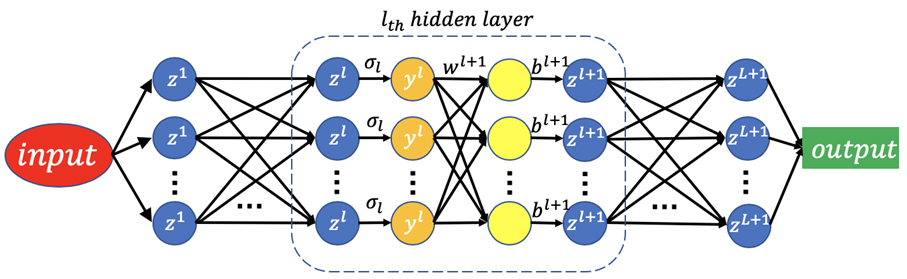

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

In [ ]:
features = ['open', 'high', 'low', 'volume', 'rsi_7', 'rsi_14', 'cci_7', 'cci_14', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14' , 'target']
X = df[features]
y = df['close']

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, shuffle=False)

In [ ]:
def create_keras_model(learning_rate=0.0001):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Regression': SVR(),
    'KNN Regressor': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'MLP Regressor': MLPRegressor(),
    'Keras Neural Network (lr=0.0001)': create_keras_model(learning_rate=0.0001),
    'Keras Neural Network (lr=0.001)': create_keras_model(learning_rate=0.001),
    'Keras Neural Network (lr=0.01)': create_keras_model(learning_rate=0.01),
}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
mse_scores = {}
best_mse = float('inf')
best_model = None

for name, model in models.items():
    if 'Keras' in name:
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

    mse_scores[name] = mse

    print(f"{name}: {mse}")
    if mse < best_mse:
        best_mse = mse
        best_model = name

print("\n📊 Model Performance Comparison (MSE):")
if best_model is not None:
    print(f"\n🏆 Best Model: {best_model}")
    print(f"🎯 Best MSE: {best_mse}")
else:
    print("❌ No valid models found!")

Linear Regression: 0.9318220405168771
Random Forest: 887.993636949532
Support Vector Regression: 5041.170777949705
KNN Regressor: 1285.4873672287729
Decision Tree: 878.0911531304541


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Regressor: 55.18869700968977
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Keras Neural Network (lr=0.0001): 1244.193486961123
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Keras Neural Network (lr=0.001): 8.981519246546284
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Keras Neural Network (lr=0.01): 6.098059950669426

📊 Model Performance Comparison (MSE):

🏆 Best Model: Linear Regression
🎯 Best MSE: 0.9318220405168771


In [ ]:
best_model_name = min(mse_scores, key=mse_scores.get)
best_model = models[best_model_name]

if 'Keras' in best_model_name:
    y_pred_best = best_model.predict(X_test)
else:
    y_pred_best = best_model.predict(X_test)

In [ ]:
train_size = int(len(df) * 0.7)
X_train_indices, X_test_indices = df.index[:train_size], df.index[train_size:]

X_test_dates = df.loc[X_test_indices, 'date']

In [ ]:
future_dates = pd.date_range(start='2023-12-31', end='2025-12-31', freq='ME')
last_data = df.iloc[-1]

X_future = pd.DataFrame(index=future_dates, columns=features)

noise_factor = 8
for feature in features:
    noise = np.random.normal(0, noise_factor, len(future_dates))
    X_future[feature] = last_data[feature] + noise
for feature in features:
    drift = np.linspace(0, 1, len(future_dates))
if X_future.isnull().sum().any():
    print("Missing values found in future data, filling them...")
    X_future.fillna(method='ffill', inplace=True)
X = df[features]
y = df['close']
model = best_model
model.fit(X, y)
y_pred_future = model.predict(X_future)

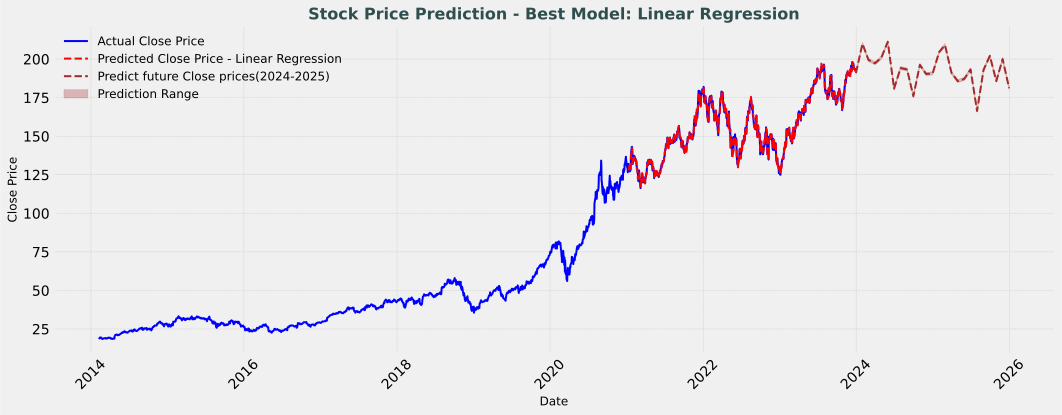

In [ ]:
std_deviation = np.std(y_pred_future) * 0.1
upper_bound = y_pred_future + std_deviation
lower_bound = y_pred_future - std_deviation

plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['close'], label='Actual Close Price', color='blue', linewidth=2)

plt.plot(X_test_dates, y_pred_best, label='Predicted Close Price - ' + best_model_name, color='red', linestyle='--', linewidth=2)

plt.plot(future_dates, y_pred_future, label='Predict future Close prices(2024-2025)', color='brown', linestyle='--', linewidth=2)

plt.fill_between(future_dates, lower_bound, upper_bound, color='brown', alpha=0.3, label='Prediction Range')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title(f"Stock Price Prediction - Best Model: {best_model_name}", fontsize=16, fontweight='bold', color='darkslategray')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.legend(fontsize=12, loc='upper left', frameon=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
MSE = pd.DataFrame({
    'Metric': ['MSE'],
    'Kalman Filter (KF)': [mse_kf],
    'Extended Kalman Filter (EKF)': [mse_ekf],
    f'{best_model}': [mse]
})

MSE.set_index('Metric', inplace=True)

MSE = MSE.applymap(lambda x: f"{x:.6f}" if pd.notnull(x) else x)

display(MSE)

<ipython-input-300-ab506d919be2>:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MSE = MSE.applymap(lambda x: f"{x:.6f}" if pd.notnull(x) else x)


,Kalman Filter (KF),Extended Kalman Filter (EKF),LinearRegression()
Metric,,,
MSE,12.492351,12.492269,6.098060


##**Conclusion:**
In this analysis, we evaluated the performance of three models: Kalman Filter (KF), Extended Kalman Filter (EKF), and Linear Regression in terms of the Mean Squared Error (MSE). The results are as follows:

*   **Kalman Filter (KF): 12.492351**

*   **Extended Kalman Filter (EKF): 12.492269**

*   **Linear Regression: 6.098060**

The Linear Regression model achieved the lowest MSE, indicating that it provided the most accurate predictions among the three models for this dataset. Both Kalman-based filters performed similarly, with slightly higher error values.

These results demonstrate the importance of selecting the appropriate machine learning (ML) tools for predictive modeling. ML tools like Kalman Filters are widely used for systems with dynamic, time-varying processes, while Linear Regression remains a solid choice for simpler, linear relationships. Understanding the strengths and limitations of each model is crucial for making informed decisions in predictive analytics.

Machine learning models help transform raw data into actionable insights, improving accuracy and aiding in real-world decision-making across industries. This study highlights the necessity of choosing models based on data characteristics and predictive goals for optimal results